# Evaluate on Test Data

## Setup

In [1]:
from importlib import reload

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas

from hot_dust import preprocess, model

2024-08-15 15:11:57.305070: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 15:11:57.412901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 15:11:57.412959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 15:11:57.430035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 15:11:57.472498: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 15:11:57.473907: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
# "reload" to get changes in preprocess.py without restarting the kernel
reload(preprocess)
reload(model)
from hot_dust.preprocess import prepare_training_data, split_training_data, sensitivity_analysis
from hot_dust.model import to_tensorflow

In [54]:
plt.rcParams["font.family"] = "helvetica"

In [6]:
ds = prepare_training_data()
train, validate, test = to_tensorflow(split_training_data(ds))
batch_size = test.cardinality()
test = test.batch(batch_size)   
ds

<xarray.Dataset>
Dimensions:   (sample: 250000, features: 9)
Coordinates:
  * features  (features) <U20 'viewing_zenith_angle' 'spress' ... 'bt_12000'
Dimensions without coordinates: sample
Data variables:
    x         (sample, features) float32 64.0 1.013e+03 68.42 ... 250.2 250.0
    y         (sample) float32 -1.826 -0.4952 -1.081 ... -1.6 -1.302 0.3864
    split     (sample) <U8 'train' 'train' 'train' ... 'train' 'train' 'train'
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 20230803
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

## Model Summary

In [7]:
network = tf.keras.models.load_model("data/network", compile=False)
network.summary() 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense (Dense)               (None, 16)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 468 (1.83 KB)
Trainable params: 449 (1.75 KB)
Non-trainable params: 19 (80.00 Byte)
_____________________________

## Metrics

In [69]:
# Calculate metrics (.eg MSE, R2) on test data and tabulate

y = np.concatenate(list(i[1] for i in test.as_numpy_iterator()))  # true values
y_hat = network.predict(test, verbose=0).reshape((-1,))  # predicted values
y_hat = y_hat[y >= -1]
y = y[y >= -1]

# Calculate the MSE
MSE = np.square(np.subtract(y, y_hat)).mean()

# Calculate R2
y_mean = np.mean(y)  # mean of the true values
SS_total = np.sum((y - y_mean) ** 2)  # total sum of squares
SS_reg = np.sum((y - y_hat) ** 2)  #  sum of squares due to regression

R2 = 1 - (SS_reg / SS_total)

# Return the metrics
print("Metrics: ")
print("Mean Squared Error: " + str(MSE))
print("Root Mean Squared Error: " + str(np.sqrt(MSE)))
print("R2: " + str(R2))

Metrics: 
Mean Squared Error: 0.02235935
Root Mean Squared Error: 0.14953044
R2: 0.9285190552473068


## Plots

findfont: Font family 'helvetica' not found.
findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'h

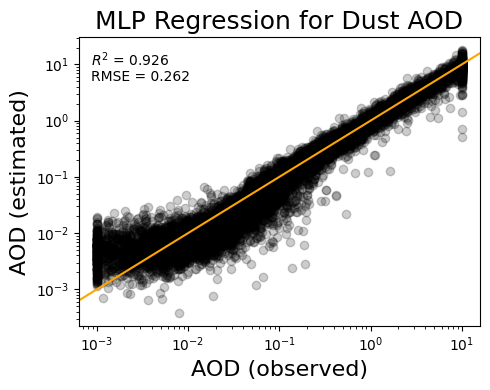

In [55]:
# Plot of y_hat against y, with a one-to-one line overlayed
fig = plt.figure(figsize=(5, 4))

# scatter plot with log_10 scale
plt.scatter(10**y, 10**y_hat, alpha=0.2, color="black")
plt.xscale("log")
plt.yscale("log")

# lables
plt.xlabel("AOD (observed)", fontsize=16)
plt.ylabel("AOD (estimated)", fontsize=16)
plt.title("MLP Regression for Dust AOD", fontsize=18)

# annotations
plt.annotate(f"$R^2$ = {R2:.3f}", (0.03, 0.9), xycoords="axes fraction")
# plt.annotate(f"MSE = {MSE:.3f}", (0.03, 0.85), xycoords="axes fraction")
plt.annotate(f"RMSE = {np.sqrt(MSE):.3f}", (0.03, 0.85), xycoords="axes fraction")

# one-to-one line overlay
plt.axline([0, 0], [1, 1], color="orange")
plt.tight_layout()
plt.savefig('figures/mlp-regression.png', dpi=300)
plt.show()

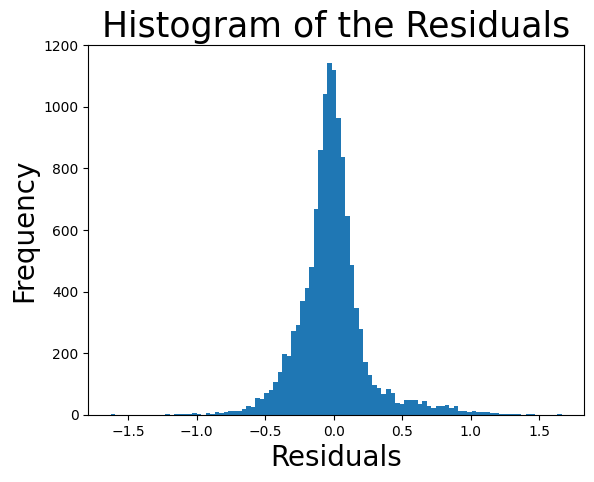

In [12]:
# Plot a histogram of the residuals
residual = y_hat - y
num_bins = 100
plt.hist(residual, num_bins)
plt.title("Histogram of the Residuals", fontsize=25)
plt.xlabel("Residuals", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.show()

Text(0.5, 1.0, 'Residuals v. True Values')

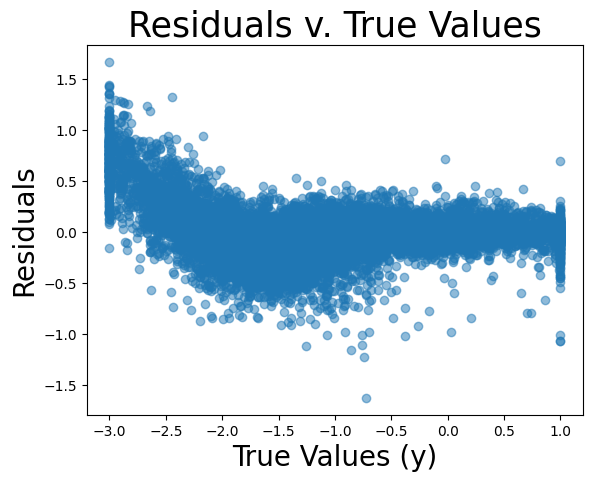

In [13]:
# Plot of the residuals against y
plt.scatter(y, residual, alpha=0.5)
# lables
plt.xlabel("True Values (y)", fontsize=20)
plt.ylabel("Residuals", fontsize=20)
plt.title("Residuals v. True Values", fontsize=25)

## Heat Maps 

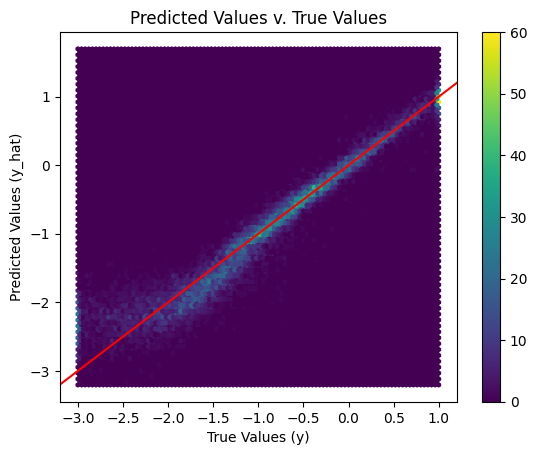

In [14]:
# Heat map of y_hat against y

# create the heatmap of y_hat against y
plt.hexbin(y, y_hat, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_hat)")
plt.title("Predicted Values v. True Values")
# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red")
plt.colorbar()

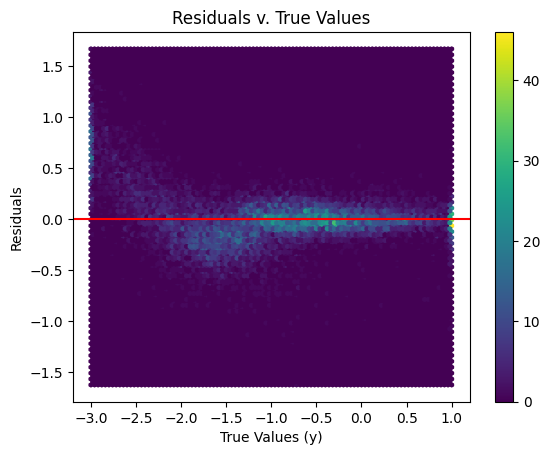

In [15]:
# Heat map of the residuals against y

# create the heatmap of residuals against y
plt.hexbin(y, residual, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Residuals")
plt.title("Residuals v. True Values")
# zero horizontal line overlay
plt.axline([0, 0], slope=0, color="red")
plt.colorbar()

## Sensitivity Analysis

7813/7813 [==============================] - 8s 1ms/step


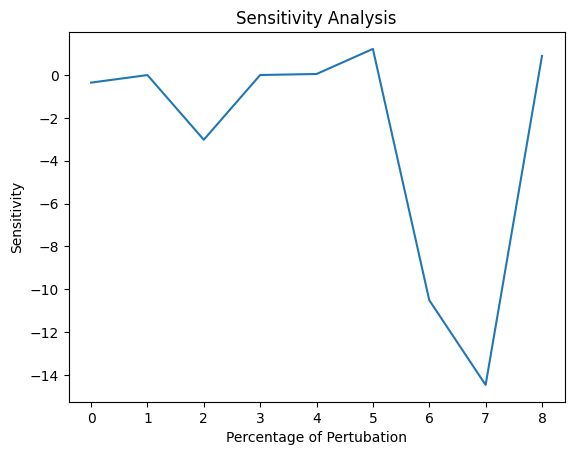

In [16]:
percentage = 2 # in %; 2%, 5%, 10%
sensitivity_analysis(ds, network, percentage)

7813/7813 [==============================] - 8s 1ms/step


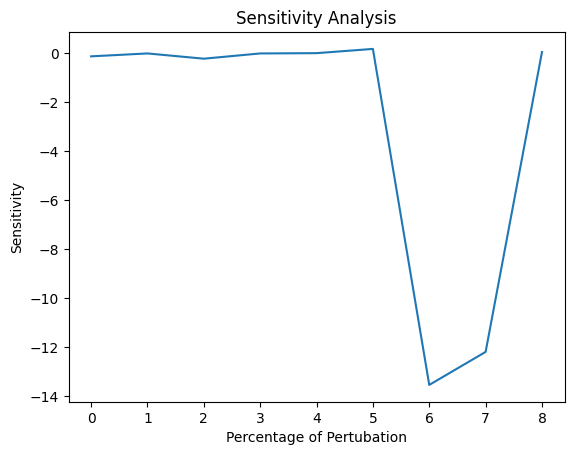

In [17]:
percentage = 10 # In %; 2%, 5%, 10%
sensitivity_analysis(ds, network, percentage)

7813/7813 [==============================] - 7s 902us/step


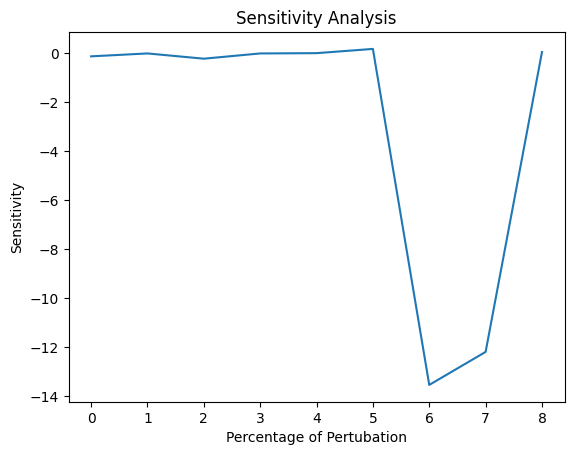

In [18]:
percentage = 10 # in %; 2%, 5%, 10%
sensitivity_analysis(ds, network, percentage)